In [1]:
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from wordcloud import WordCloud

In [2]:
sns.set_theme()

In [3]:
with open("models/01_tfidf_vectorizer_fitted.joblib", "rb") as vFile:
    vectorizer = joblib.load(vFile)
    
with open("models/02_chi2_250_feature_selector_fitted.joblib", "rb") as fsFile:
    feature_selector = joblib.load(fsFile)
    
with open("models/03_random_forest_model_fitted.joblib", "rb") as rfFile:
    random_forest_clf = joblib.load(rfFile)

In [4]:
# Loading kurzgesagt data created in the notebook 02
kurz_comments_df = pd.read_feather("data/kurzgesagt_clean.feather")
kurz_comments_df["comment"] = kurz_comments_df["comment"].transform(list)
kurz_comments_df.head()

,comment
0,"[head, shop, exclusive, kurzgesagt, merch, sci..."
1,"[6, different, type, human, wild, mind, blown]"
2,"[think, primitive, human, woman, wear, bikini,..."
3,"[wish, never, leave, cave, human, animal, duty..."
4,"[together, clip, kardashev, scale, really, cre..."


## Polarity prediction + brief EDA

In [5]:
kurz_vect = vectorizer.transform(kurz_comments_df.comment.apply(" ".join))
kurz_chi2 = feature_selector.transform(kurz_vect)
kurz_polarity = random_forest_clf.predict(kurz_chi2)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    2.1s finished


In [6]:
map_classes = {
    
    0:"Negative",
    1:"Other",
    2:"Positive"
}

kurz_polarity = pd.Series(kurz_polarity).map(map_classes)
kurz_comments_df["class"] = list(kurz_polarity)

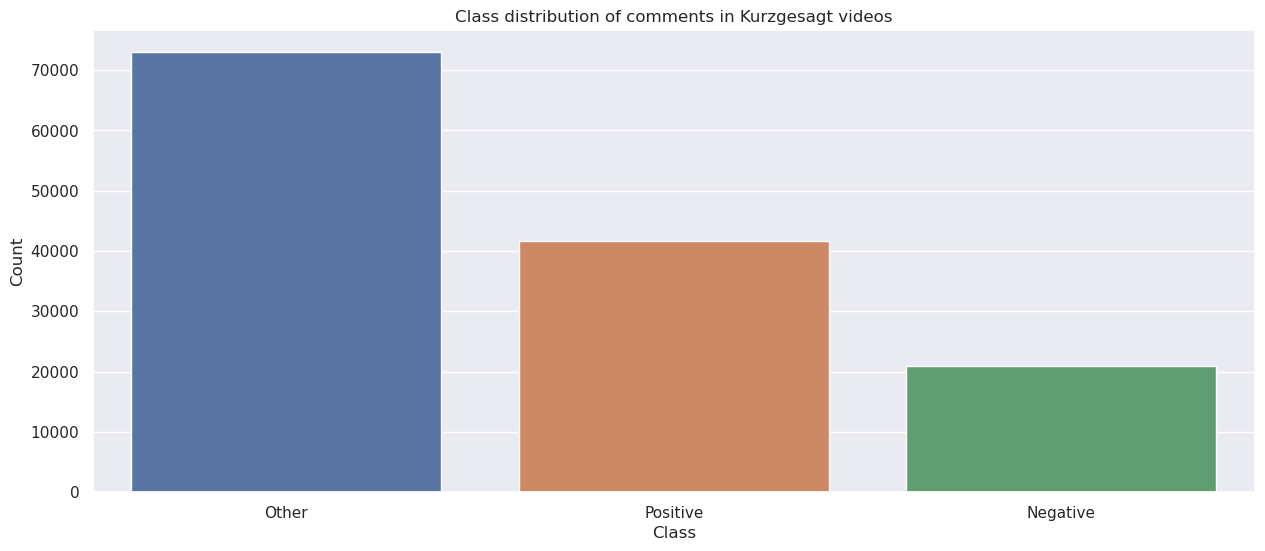

In [7]:
polarity_counts = kurz_polarity.value_counts().to_frame().reset_index()
polarity_counts.columns = ["Class","Count"]

plt.figure(figsize=(15,6))
sns.barplot(data = polarity_counts, x="Class", y="Count")
plt.title("Class distribution of comments in Kurzgesagt videos")
plt.show()

In [8]:
kurz_comments_positive = kurz_comments_df[kurz_comments_df["class"] == "Positive"]
kurz_comments_negative = kurz_comments_df[kurz_comments_df["class"] == "Negative"]

pos_comments_string = " ".join(kurz_comments_positive.comment.apply(" ".join).to_list())
neg_comments_string = " ".join(kurz_comments_negative.comment.apply(" ".join).to_list())

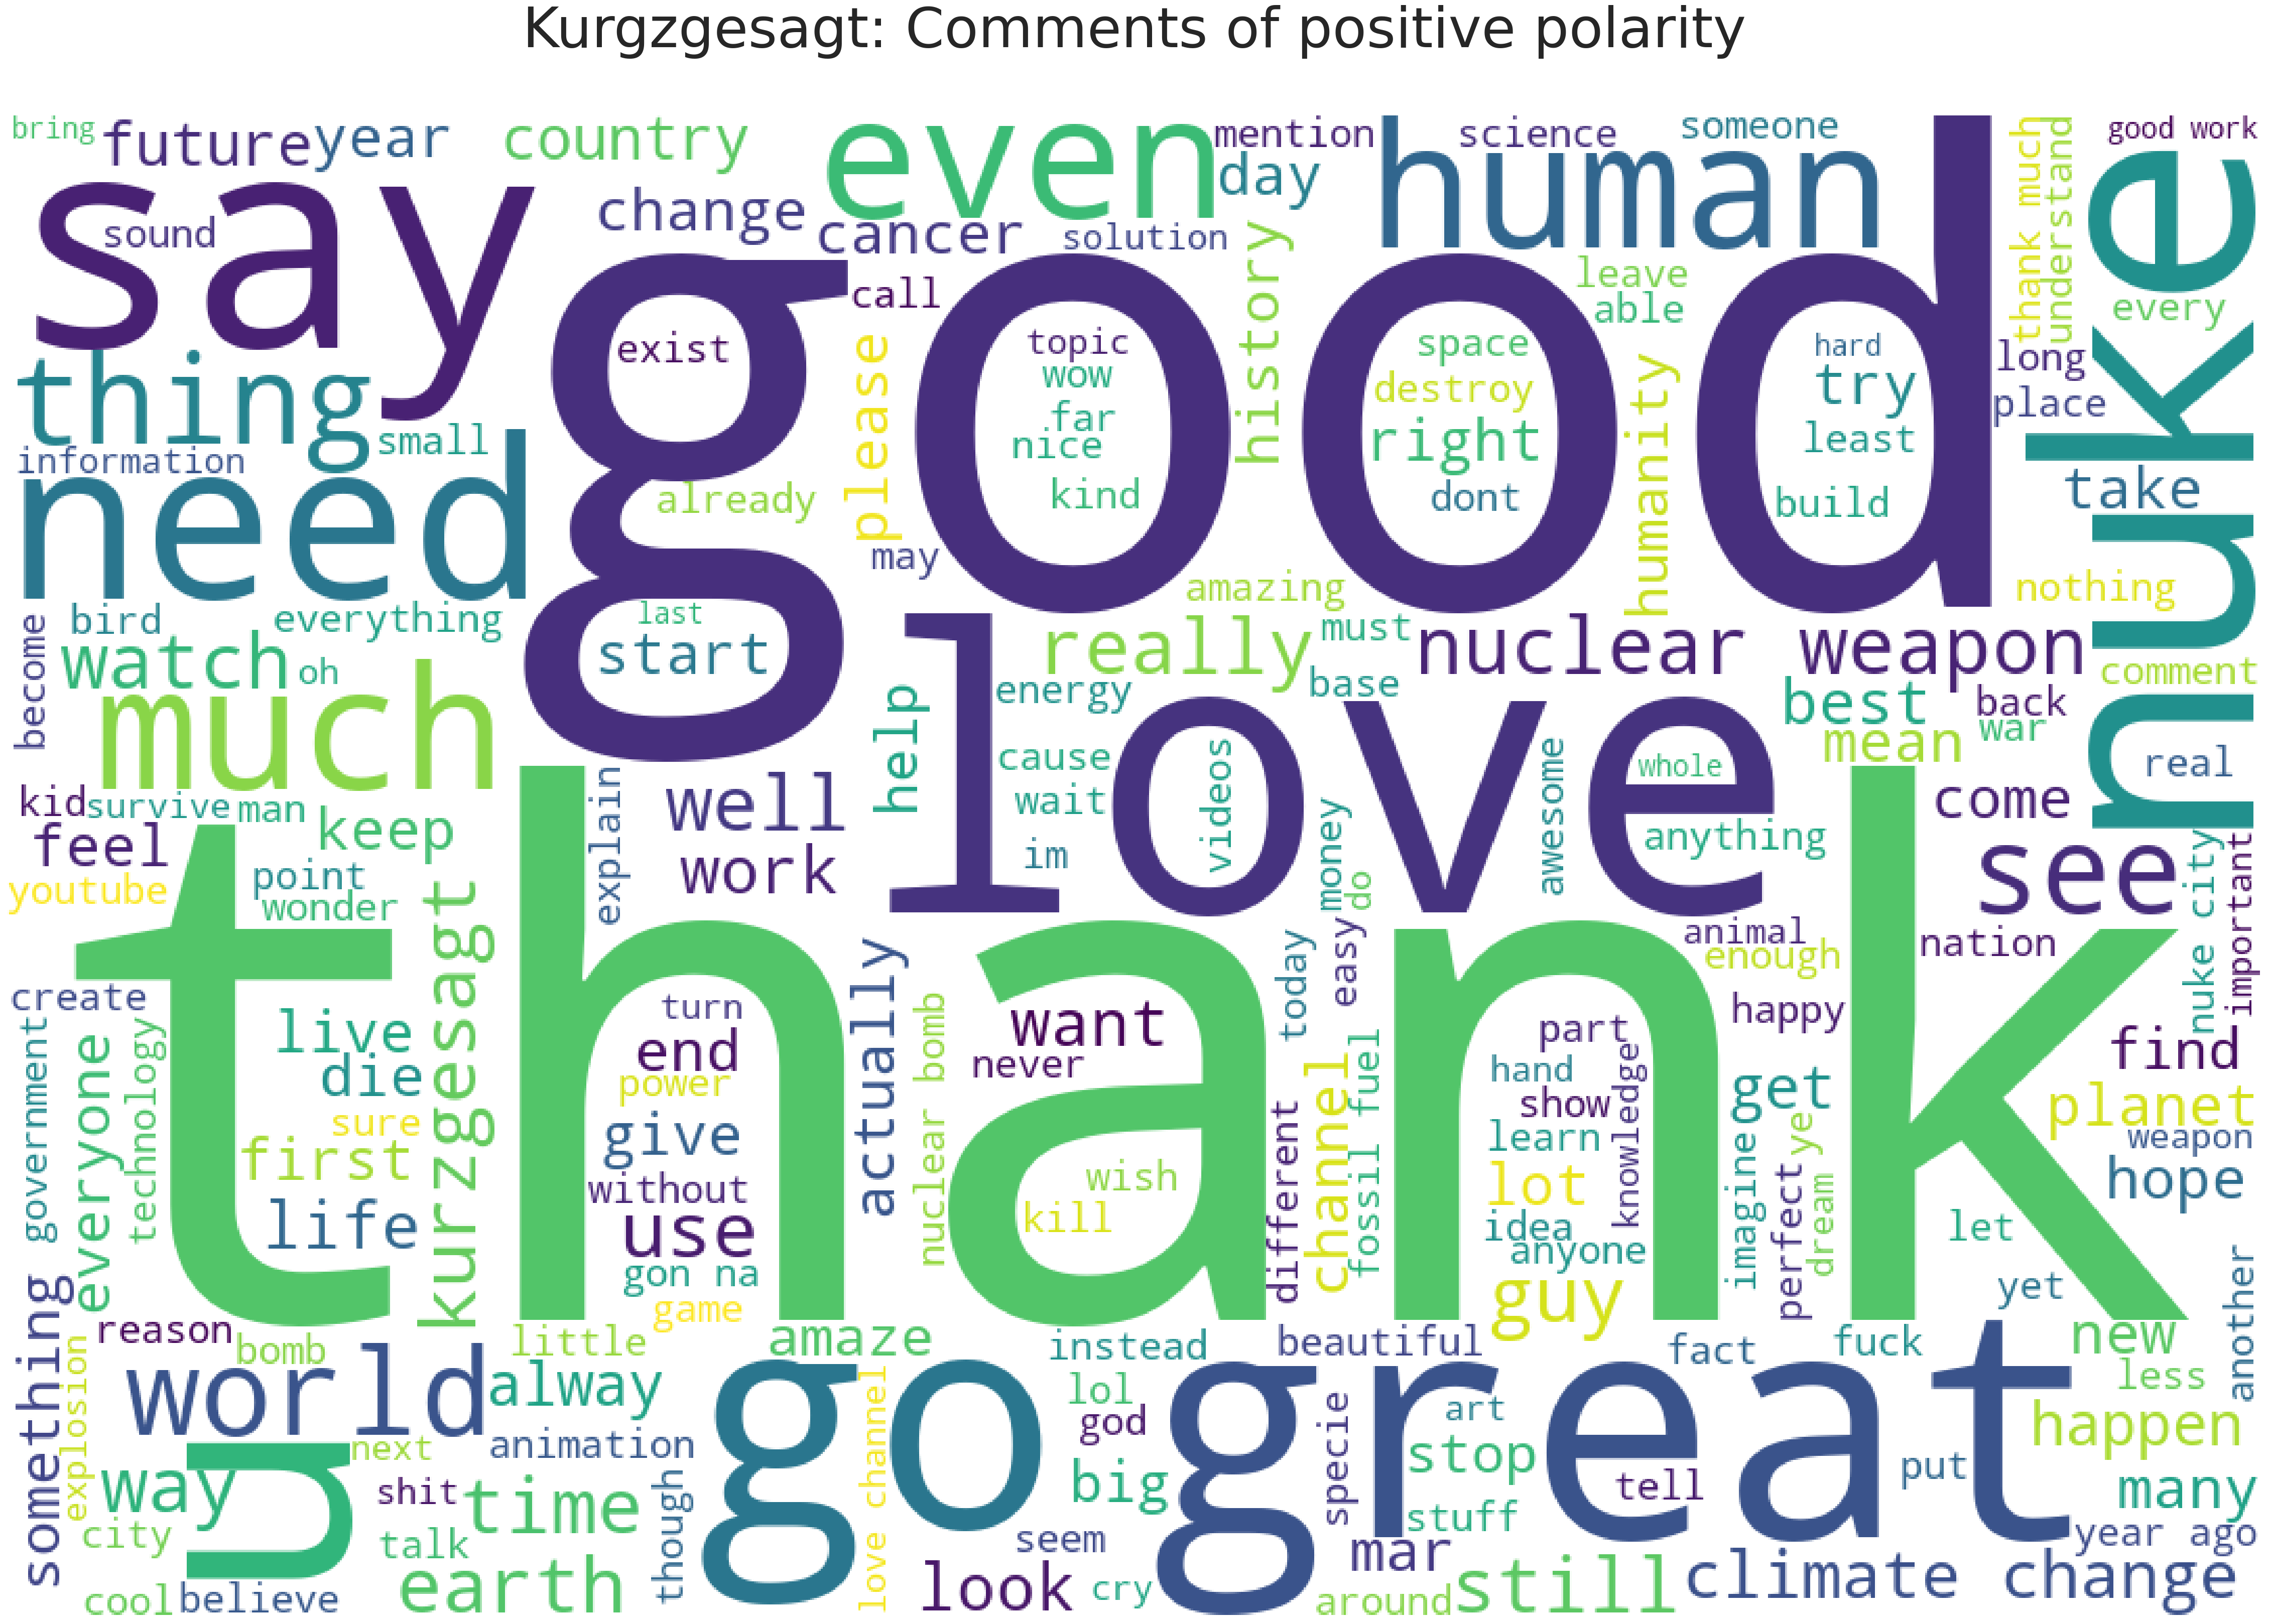

In [9]:
remove_words = ["make", "think", "video", "one", "people", "know"]

cloud = WordCloud(width=1080, height=720,
                  background_color="white", stopwords = remove_words,
                  min_font_size = 10).generate_from_text(pos_comments_string)

plt.figure(figsize = (45, 45), facecolor = None)
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.title("Kurgzgesagt: Comments of positive polarity\n", fontdict={"size":80})
plt.show()

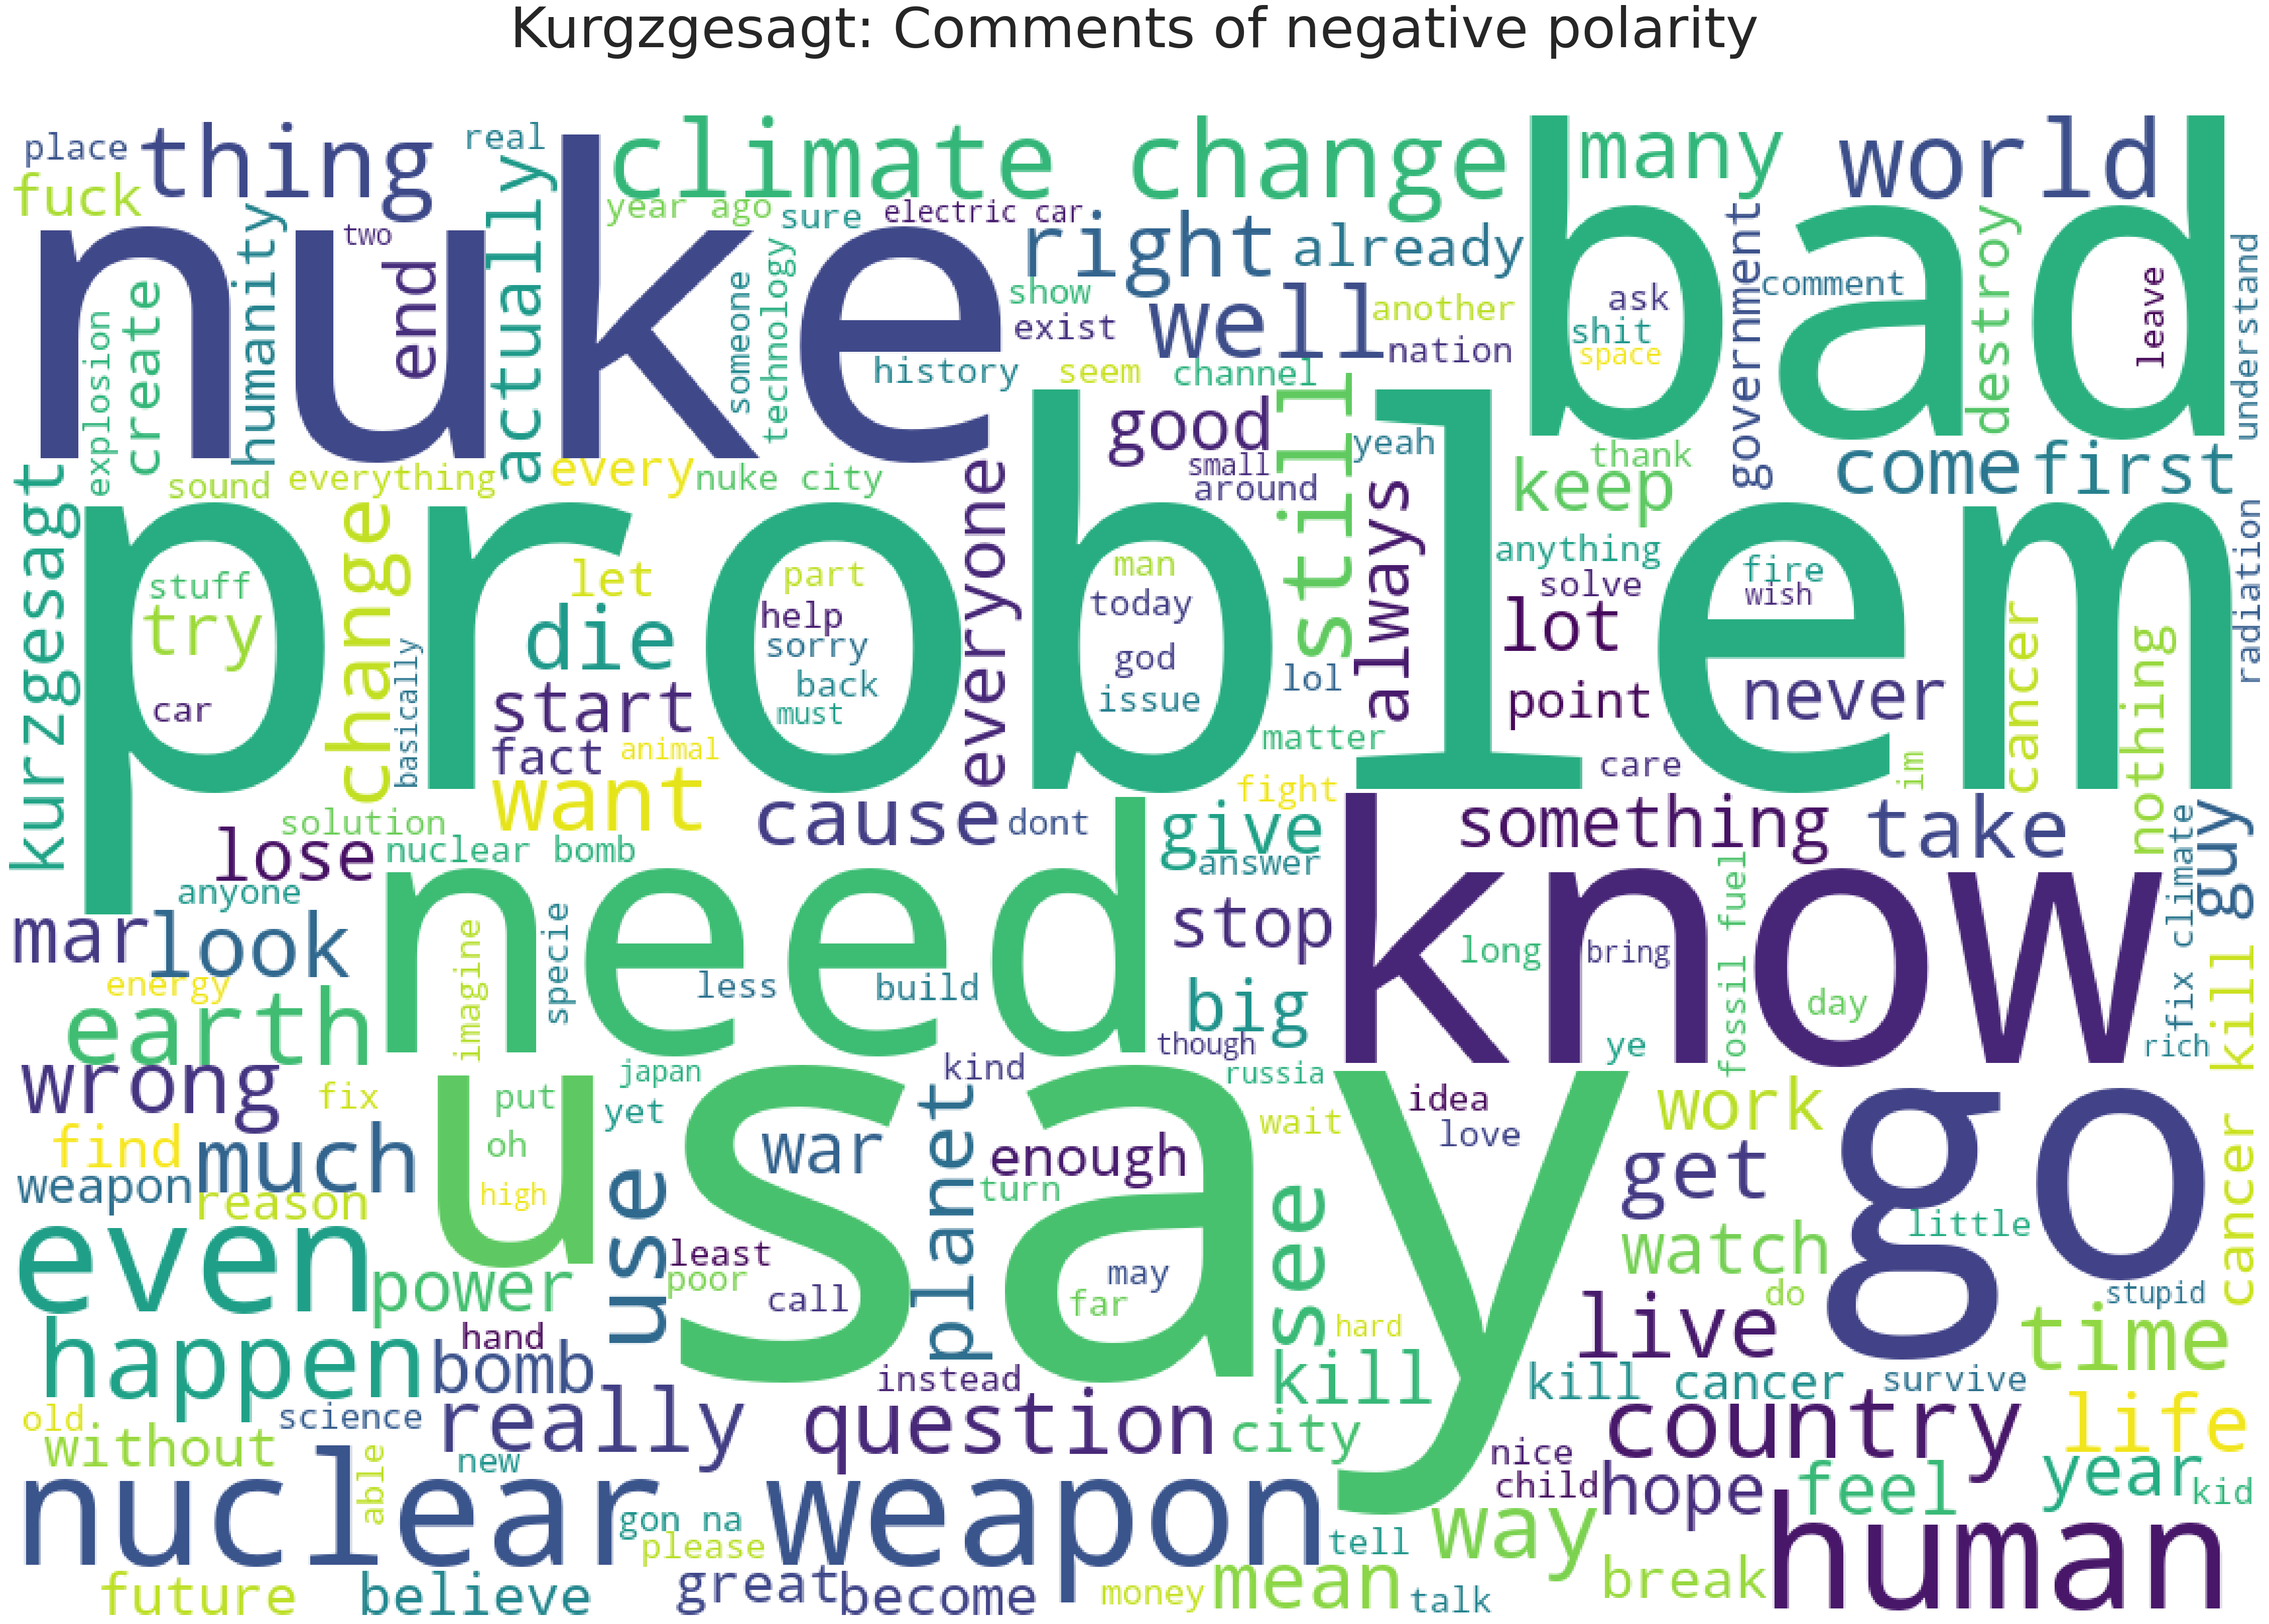

In [10]:
cloud = WordCloud(width=1080, height=720,
                  background_color="white", stopwords=["make", "think", "video", "one", "people"],
                  min_font_size = 10).generate_from_text(neg_comments_string)

plt.figure(figsize = (45, 45), facecolor = None)
plt.imshow(cloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.title("Kurgzgesagt: Comments of negative polarity\n", fontdict={"size":80})
plt.show()

## Most important words

In [11]:
# Retrieving vocab and scores of each word

vocab_tfidf = pd.DataFrame(vectorizer.vocabulary_.items())
vocab_tfidf.columns = ["Word", "index"]
vocab_tfidf.set_index("index", inplace=True)

vocab_scores = pd.DataFrame(feature_selector.scores_, columns=["Scores"])

print(vocab_tfidf.shape)
print(vocab_scores.shape)

(27110, 1)
(27110, 1)


In [12]:
# Joining words with their scores
important_features = vocab_tfidf.merge(vocab_scores, how="left", left_index=True, right_index=True)
important_features.isna().any()

Word      False
Scores    False
dtype: bool

In [13]:
most_important_k_words = important_features.sort_values(by="Scores", ascending = False).iloc[:250]

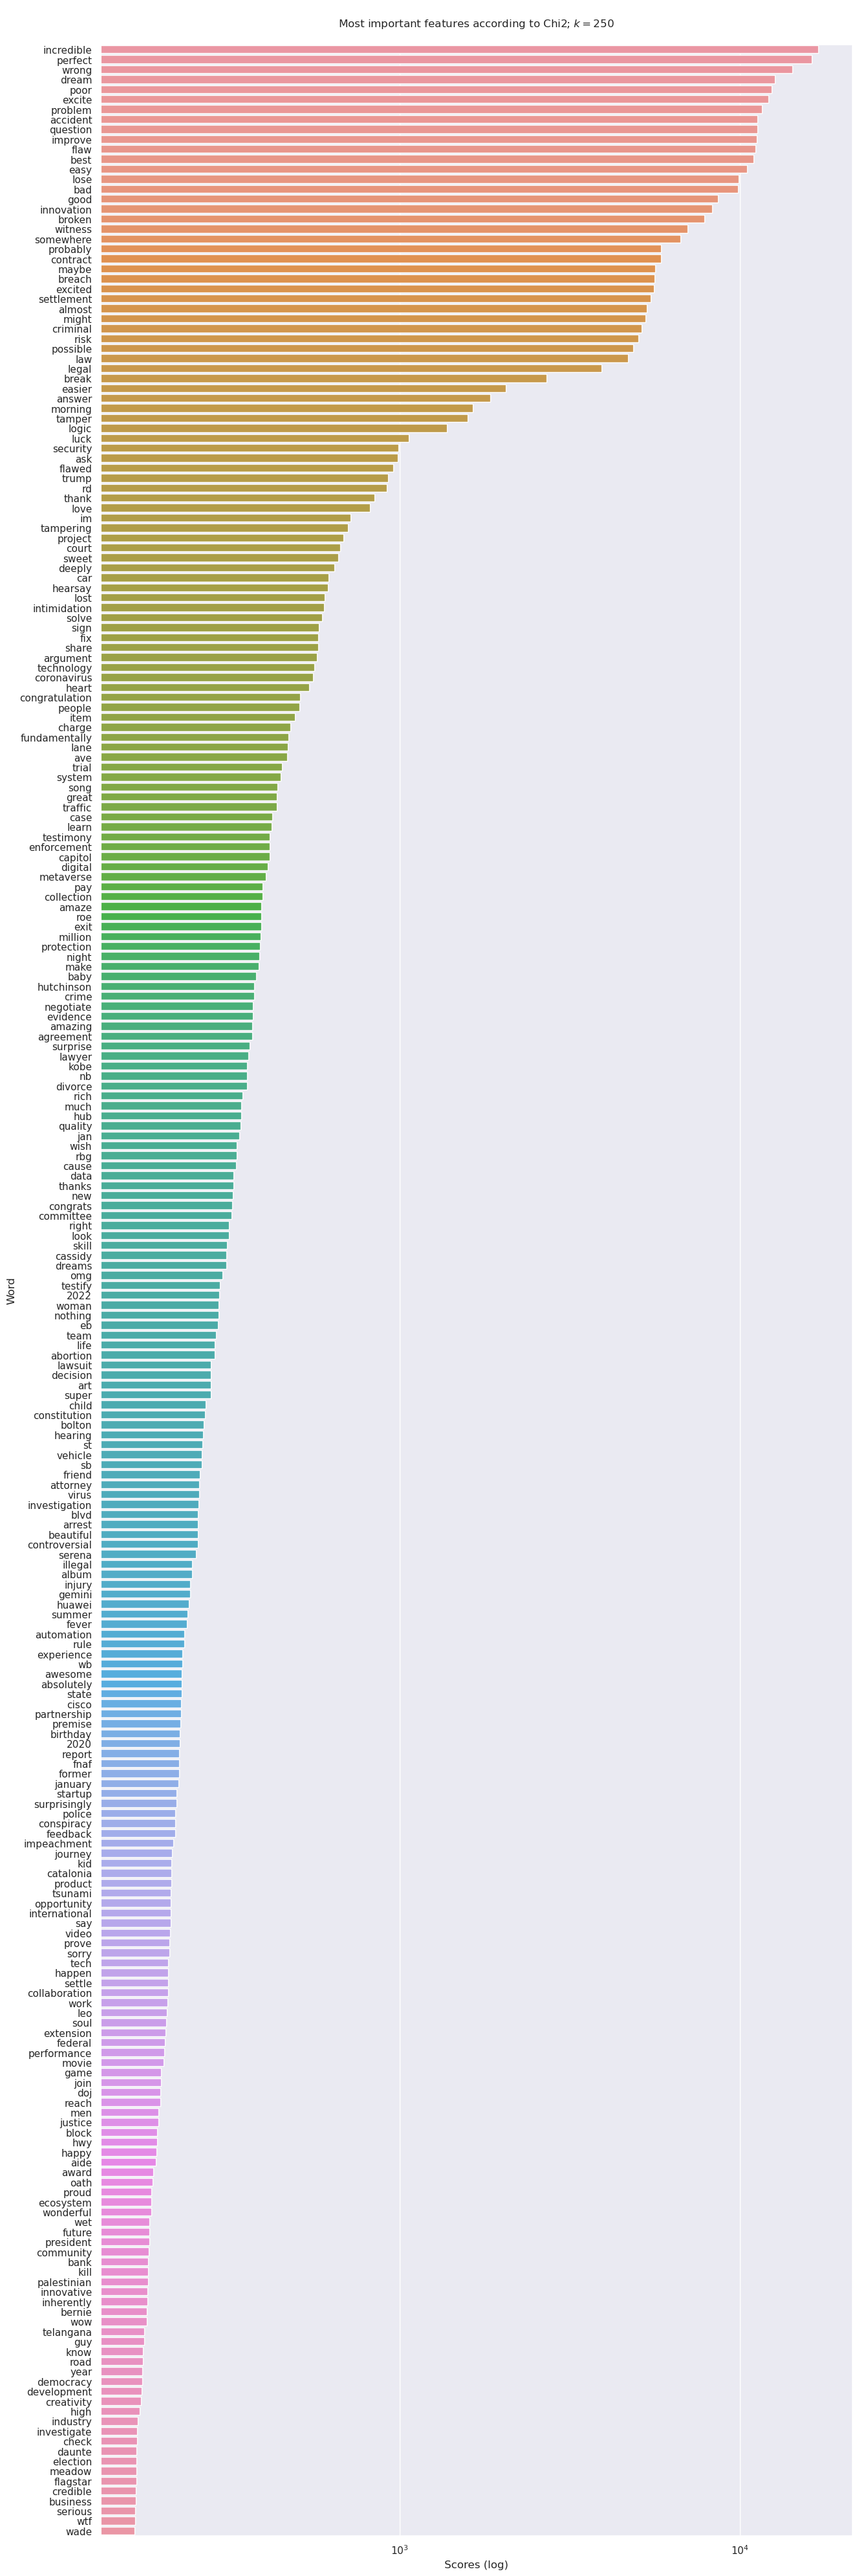

In [14]:
fig, axis = plt.subplots(1,1, figsize=(15,50))

sns.barplot(data = most_important_k_words, x = "Scores", y = "Word", ax=axis)

axis.set_xscale("log")
axis.set_xlabel("Scores (log)")
axis.set_title("\nMost important features according to Chi2; $k=250$\n")

plt.show()